In [1]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
from fracModel import fracOrdUU
import os
import numpy as np

0.23.0


In [2]:
# To load graphs using Qt console
matplotlib.use('Qt5Agg')

In [3]:
# Data of a go/no-go task originally taken from https://openneuro.org/datasets/ds003690/versions/1.0.0
edata = np.load("data/Audata.npz")["X"]
Y = np.load("data/Audata.npz")["y"]

In [4]:
edata = edata*1e6    #Scale so that EM algo works

In [5]:
edata[0]

array([[ -5.15470755,  -3.14432874,  -2.0314145 , ...,  -1.63594349,
          0.10067975,   2.21421123],
       [ -5.83107443,  -3.52958872,  -1.98812517, ...,  -4.61134055,
         -1.88496661,   0.94532055],
       [ -3.8391348 ,  -2.85403036,  -1.88846885, ...,   2.66928381,
          4.54302294,   6.16168077],
       ...,
       [ -5.38114064,  -4.77771393,  -4.1721551 , ...,   3.12278397,
          4.72275601,   6.30938749],
       [ -4.33310438,  -3.67027474,  -3.17584185, ...,   4.6567451 ,
          6.783997  ,   8.9434462 ],
       [  0.20419303,   2.00336793,   1.75149337, ..., -17.06967326,
        -13.38565904,  -7.69476296]])

In [6]:
print(edata.shape)
print(Y.shape)

(1077, 11, 351)
(1077,)


In [7]:
def get_laplace_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X, 1)
    
    return fModel._AMat[-1]

def get_gaussian_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X, 2)
    
    return fModel._AMat[-1]

In [8]:
# To get A with Laplacian prior (Takes 30+ min)
# Adata = np.stack([get_laplacian_A(x) for x in edata])

# To get A with Gaussian prior
# Adata = np.stack([get_gaussian_A(x) for x in edata])

# Since it takes so long to load it with a Laplacian prior, we have already cached it in data
# Adata = np.load("save/AdataAuL.npz")["Adata"]
# Y = np.load("save/AdataAuL.npz")["Y"]

In [9]:
# If you want to save your data
# np.savez('AdataAu.npz', Adata = Adata, Y = Y)

#### Feature extraction

In [10]:
# If you are loading from a saved location
# Adata = np.load("AdataAuL.npz")["Adata"]
# Y = np.load("AdataAuL.npz")["Y"]

In [11]:
Ago = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==2])
Anogo = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==4])
Abp = np.stack([Adata[i] for i in range(Adata.shape[0]) if Y[i]==5])

In [12]:
Ygo = np.stack([Y[i] for i in range(Adata.shape[0]) if Y[i]==2])
Ybp = np.stack([Y[i] for i in range(Adata.shape[0]) if Y[i]==5])

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
AgoAv = np.average(Ago, axis = 0)
AnogoAv = np.average(Anogo, axis = 0)
AbpAv = np.average(Abp, axis = 0)

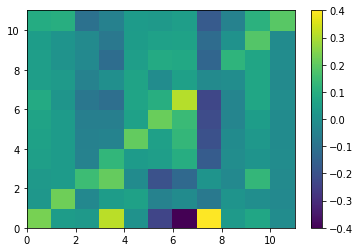

In [15]:
fig = plt.figure()
f = plt.pcolormesh(AgoAv, vmin=-0.4, vmax=0.4)
plt.colorbar(f)

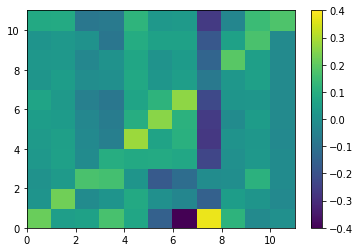

In [16]:
fig = plt.figure()
f = plt.pcolormesh(AbpAv, vmin=-0.4, vmax=0.4)
plt.colorbar(f)

## Applying ML

In [17]:
X = np.stack([np.concatenate([a[:, i] for i in range(11)]) for a in np.concatenate([Ago, Abp])])

In [18]:
Y = np.concatenate([Ygo, Ybp])

In [19]:
Y.shape

(957,)

In [20]:
X.shape

(957, 121)

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
Logclassifier = LogisticRegression(random_state = 0, max_iter = 1000)
Logclassifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred_log = Logclassifier.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

[[55 34]
 [68 35]]


In [25]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Logclassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 52.14 %
Standard Deviation: 7.67 %


#### Kernal SVM

In [26]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'rbf', random_state = 0)
SVCclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [27]:
y_pred_SVC = SVCclassifier.predict(X_test)

In [28]:
y_pred_SVC

array([2., 2., 2., 2., 5., 2., 5., 2., 2., 5., 2., 2., 5., 5., 5., 5., 5.,
       2., 2., 2., 5., 5., 2., 5., 5., 2., 2., 2., 2., 5., 2., 5., 2., 2.,
       2., 2., 5., 5., 2., 2., 5., 2., 2., 2., 5., 2., 5., 5., 5., 2., 2.,
       5., 2., 2., 2., 2., 2., 5., 2., 5., 5., 2., 2., 2., 5., 5., 2., 5.,
       5., 2., 2., 2., 2., 5., 2., 5., 2., 5., 5., 2., 5., 5., 5., 2., 2.,
       2., 2., 2., 5., 5., 5., 2., 2., 2., 2., 5., 2., 2., 5., 2., 2., 2.,
       2., 2., 2., 2., 5., 2., 5., 2., 2., 5., 5., 2., 2., 2., 5., 2., 2.,
       5., 2., 2., 2., 5., 2., 2., 5., 2., 2., 5., 2., 5., 2., 5., 2., 5.,
       5., 5., 2., 2., 2., 2., 5., 2., 2., 5., 2., 5., 2., 5., 2., 5., 2.,
       2., 5., 2., 2., 5., 2., 2., 2., 5., 2., 5., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 5., 2., 2., 5., 5., 2., 5., 2., 5., 5., 2., 2., 5., 2.,
       2., 2., 2., 2., 5.])

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_SVC)
print(cm)
accuracy_score(y_test, y_pred_SVC)

[[54 35]
 [66 37]]


0.4739583333333333

#### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
y_pred_RF = RFclassifier.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_RF)
print(cm)
accuracy_score(y_test, y_pred_RF)

[[62 27]
 [72 31]]


0.484375

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
KNNclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [34]:
y_pred_KNN = KNNclassifier.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_KNN)
print(cm)
accuracy_score(y_test, y_pred_KNN)

[[39 50]
 [63 40]]


0.4114583333333333

#### Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [37]:
y_pred_NB = NBclassifier.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_NB)
print(cm)
accuracy_score(y_test, y_pred_NB)

[[75 14]
 [88 15]]


0.46875

#### MLP

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [42]:
dict = {2: 0,5: 1}

for i in range(len(y_train)):
    y_train[i] = dict[y_train[i]]
    
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [43]:
for i in range(len(y_test)):
    y_test[i] = dict[y_test[i]]
    
num_classes = 2
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [44]:
ip = tf.keras.Input(shape = 121)
dense1 = tf.keras.layers.Dense(units = 32, activation = "relu")(ip)
dense2 = tf.keras.layers.Dense(units = 32, activation = "relu")(dense1)
dense3 = tf.keras.layers.Dense(units = 16, activation = "relu")(dense2)
dense4 = tf.keras.layers.Dense(units = 8, activation = "relu")(dense3)
dense4 = tf.keras.layers.Dense(units = 2, activation = "sigmoid")(ip)

Model = tf.keras.models.Model(inputs = ip, outputs = dense4)
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 244       
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________


In [45]:
Model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [46]:
history = Model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

Epoch 1/200
24/24 [==============================] - 2s 7ms/step - loss: 0.7812 - acc: 0.4941 - val_loss: 0.7624 - val_acc: 0.5573
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7574 - acc: 0.5020 - val_loss: 0.7528 - val_acc: 0.5417
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7411 - acc: 0.5046 - val_loss: 0.7478 - val_acc: 0.5365
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7283 - acc: 0.5137 - val_loss: 0.7475 - val_acc: 0.5417
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7194 - acc: 0.5150 - val_loss: 0.7473 - val_acc: 0.5156
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7113 - acc: 0.5242 - val_loss: 0.7487 - val_acc: 0.4948
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7053 - acc: 0.5359 - val_loss: 0.7486 - val_acc: 0.4844
Epoch 8/200
24/24 [==============================] - 0s 2ms/step - loss: 0.7001 - a

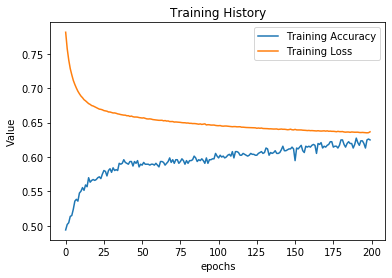

Initial training accuracy with preprocessing is:  0.4941176474094391
Final training accuracy with preprocessing is:  0.6248366236686707
Initial training loss with preprocessing is:  0.7812291979789734
Final training loss with preprocessing is:  0.6366053223609924


In [47]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

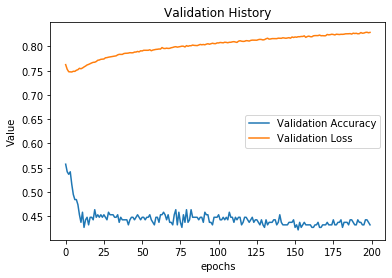

Initial Validation accuracy is:  0.5572916865348816
Best Validation accuracy is:  0.5572916865348816
Initial Validation loss is:  0.7624233365058899
Best Validation loss is:  0.7473006844520569


In [48]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))